# Курсовой проект

### Задача

#### Статистическое изучение курса цены EUR к USD со дня ее основания (1.11.1993). Сделать прогноз курса EUR/USD на 2023 год.

In [484]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
#from scipy import stats
%matplotlib inline

matplotlib.rcParams.update({'font.size': 14})

import warnings
warnings.filterwarnings('ignore')

#### 1. Загрузка данных и первое ознакомление

In [485]:
df = pd.read_csv('USD_EUR.csv', sep=',')

df

,Date,Price,Price_open,Price_max,Price_min
0,2022-07-29,0.9783,0.9806,0.9857,0.9751
1,2022-07-28,0.9806,0.9806,0.9887,0.9769
2,2022-07-27,0.9798,0.9884,0.9905,0.9783
3,2022-07-26,0.9883,0.9785,0.9894,0.9754
4,2022-07-25,0.9781,0.9792,0.9824,0.9748
...,...,...,...,...,...
7449,1993-11-05,0.8734,0.8734,0.8734,0.8734
7450,1993-11-04,0.8715,0.8715,0.8715,0.8715
7451,1993-11-03,0.8710,0.8710,0.8710,0.8710
7452,1993-11-02,0.8721,0.8721,0.8721,0.8721


In [486]:
df['Date'] = df['Date'].astype(np.datetime64)  # сделаем признак Date спецформата для комфортной работы

In [487]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7454 entries, 0 to 7453
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        7454 non-null   datetime64[ns]
 1   Price       7454 non-null   float64       
 2   Price_open  7454 non-null   float64       
 3   Price_max   7454 non-null   float64       
 4   Price_min   7454 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 291.3 KB


Описание датасета.

Пердставлены внутридневные цены валютной пары EUR/USD в период 1.11.1993--29.07.2022 г. (10497 календарных дней или 28 лет 8 месяцев и 27 дней).

Валютный рынок работает Пн-Пт, Сб-Вс -- выходные, поэтому датасет состоит из 7454 наблюдений:

Date -- дата торгов
Price -- зафиксированная цена курса валютной пары EUR/USD
Price_open -- цена открытия
Price_max -- максимальная цена за день
Price_min -- минимальная цена за день

In [488]:
df.describe()

,Price,Price_open,Price_max,Price_min
count,7454.000000,7454.000000,7454.000000,7454.000000
mean,0.847918,0.847539,0.851201,0.844378
std,0.111548,0.111839,0.112413,0.111022
min,0.625300,0.625100,0.630200,0.623400
25%,0.766525,0.764825,0.769500,0.762700
50%,0.837800,0.837800,0.840300,0.835050
75%,0.903275,0.904200,0.905875,0.901500
max,1.208900,1.208800,1.215700,1.200900


In [489]:
df['Price'].quantile(0.90), df['Price'].quantile(0.91)

(0.99254, 1.0158)

Посмотрим это на гистограмме:

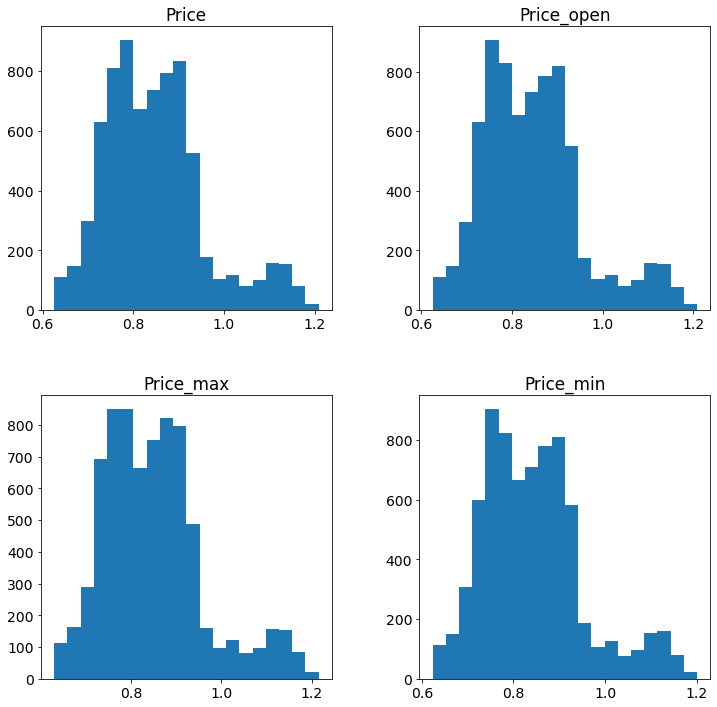

In [490]:
df[['Price', 'Price_open', 'Price_max', 'Price_min']].hist(figsize=(12,12), bins=20, grid=False);

#### 2. Расчеты

In [491]:
mode_price = df.Price.mode()
mode_price

0    0.735
1    0.747
Name: Price, dtype: float64

Мультимодальное распределение, т.к. две моды. Средний курс евро к доллару:

In [492]:
mean_price = df.Price.mean()
mean_price

0.8479183793936121

Медиана близка к среднему курсу:

In [493]:
median_price = df.Price.median()
median_price

0.8378

Средний курс евро к доллару из всех зафиксированных (минимальные, максимальные, открытия, закрытия) равен среднему курсу по закрытию:

In [494]:
mean_all = np.concatenate([df.Price, df.Price_open, df.Price_max, df.Price_min]).mean()
mean_all

0.8477589784008586

In [495]:
round(mean_all.mean(), 3) == round(mean_price, 3)

True

Т.е. перед нами нормальное распределение.

Минимумы:

In [496]:
min_all = df[['Price', 'Price_open', 'Price_max', 'Price_min']].min()
min_all

Price         0.6253
Price_open    0.6251
Price_max     0.6302
Price_min     0.6234
dtype: float64

In [497]:
min_all.min()

0.6234

Максимумы:

In [498]:
max_all = df[['Price', 'Price_open', 'Price_max', 'Price_min']].max()
max_all

Price         1.2089
Price_open    1.2088
Price_max     1.2157
Price_min     1.2009
dtype: float64

In [499]:
max_all.max()

1.2157

Отобразим статистические данные на графике курса евро к доллару с группировкой по годам:

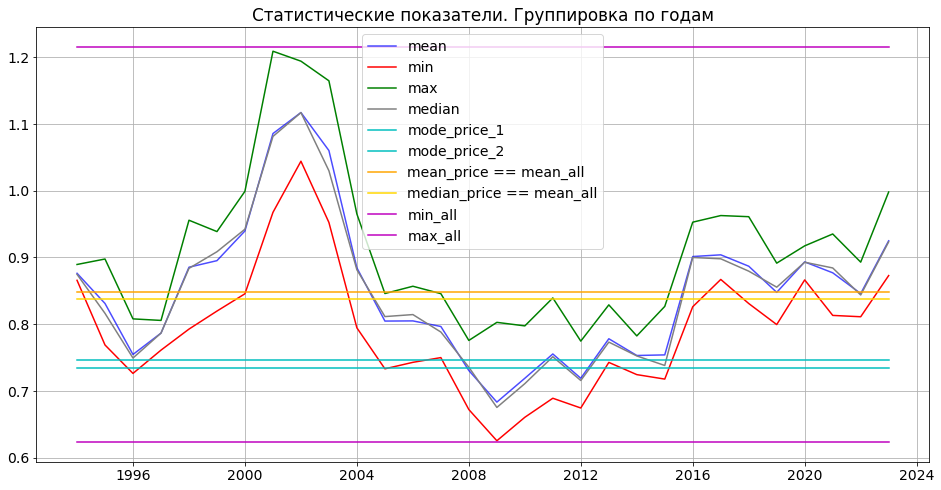

In [500]:
mean_y_price = df.groupby([pd.Grouper(key='Date', freq='Y')]).agg(mean_year=('Price', 'mean')).reset_index()
min_y_price = df.groupby([pd.Grouper(key='Date', freq='Y')]).agg(min_year=('Price', 'min')).reset_index()
max_y_price = df.groupby([pd.Grouper(key='Date', freq='Y')]).agg(max_year=('Price', 'max')).reset_index()
median_y_price = df.groupby([pd.Grouper(key='Date', freq='Y')]).agg(median_year=('Price', 'median')).reset_index()

plt.figure(figsize=(16, 8))

plt.plot(mean_y_price['Date'], mean_y_price['mean_year'], alpha=0.7, label="mean", c='b')
plt.plot(min_y_price['Date'], min_y_price['min_year'], label="min", c='r')
plt.plot(max_y_price['Date'], max_y_price['max_year'], label="max", c='g')
plt.plot(median_y_price['Date'], median_y_price['median_year'], label="median", c='gray')

plt.plot(min_y_price['Date'], np.array([mode_price[0]] * 30), label="mode_price_1", c='c')
plt.plot(min_y_price['Date'], np.array([mode_price[1]] * 30), label="mode_price_2", c='c')
plt.plot(min_y_price['Date'], np.array([mean_price] * 30), label="mean_price == mean_all", c='orange')
plt.plot(min_y_price['Date'], np.array([median_price] * 30), label="median_price == mean_all", c='gold')

plt.plot(min_y_price['Date'], np.array([min_all.min()] * 30), label="min_all", c='m')
plt.plot(min_y_price['Date'], np.array([max_all.max()] * 30), label="max_all", c='m')

plt.title('Статистические показатели. Группировка по годам')
plt.legend()
plt.grid(True)

За 28,5 лет существования евро его курс можно сказать не изменился. Посмотрим дисперсию по дневному курсу (смещенную):

In [501]:
price_variance = round(df['Price'].var(ddof=0), 4)
price_variance

0.0124

Несмещенная дисперсия по дневному курсу:

In [502]:
round(df['Price'].var(ddof=1), 4)

0.0124

Смещенная и несмещенная дисперсии совпадают.

Cреднее квадратичное отклонение по дневному курсу:

In [503]:
sq_price = round(df['Price'].std(ddof=0), 4)
sq_price

0.1115

Несущественный разброс цен. 

Курс валютной пары может расти, падать или оставаться в одном ценовом коридоре (горизонтальный тренд), т.е. три варианта развития событий. 

Посмотрим как менялся курс евро к доллару от дня к дню (в положительную или отрицательную сторону или вовсе не изменялся). Для этого создадим доппризнак и отметим в нем 0 дни когда курс менялся в отрицательную сторону, 1 -- изменение в положительную сторону и 2 -- если курс по отношению к предыдущему дню не менялся:

In [504]:
df['Price_change'] = 0

for i in range(df.shape[0] - 1):
    if df['Price'][i] > df['Price'][i + 1]:
        df['Price_change'][i] = 1
    elif df['Price'][i] == df['Price'][i + 1]:
        df['Price_change'][i] = 2
    
df.head(10)

,Date,Price,Price_open,Price_max,Price_min,Price_change
0,2022-07-29,0.9783,0.9806,0.9857,0.9751,0
1,2022-07-28,0.9806,0.9806,0.9887,0.9769,1
2,2022-07-27,0.9798,0.9884,0.9905,0.9783,0
3,2022-07-26,0.9883,0.9785,0.9894,0.9754,1
4,2022-07-25,0.9781,0.9792,0.9824,0.9748,0
5,2022-07-22,0.9790,0.9776,0.9872,0.9750,1
6,2022-07-21,0.9773,0.9825,0.9848,0.9729,0
7,2022-07-20,0.9822,0.9779,0.9847,0.9733,1
8,2022-07-19,0.9777,0.9860,0.9882,0.9737,0
9,2022-07-18,0.9858,0.9916,0.9923,0.9801,0


In [505]:
df.Price_change.value_counts()

0    3686
1    3681
2      87
Name: Price_change, dtype: int64

Выразим эти данные в относительной частоте того или иного события:

In [506]:
round(df.Price_change.value_counts()[2] / df.shape[0], 3)  # относительная частота горизонтального тренда

0.012

In [507]:
round(df.Price_change.value_counts()[1] / df.shape[0], 3)  # относительная частота роста дневного курса евро к доллару

0.494

In [508]:
round(df.Price_change.value_counts()[0] / df.shape[0], 3)  # относительная частота понижения дневного курса евро к доллару

0.494

Одинаковая относительная частота роста и падения. Но это только относительная частота события, а курс за одно какое-либо событие мог меняться сразу на несколько пунктов в одном случае, а в другом меньше или больше. Посмотрим изменение курса в пунктах от дня к дню.

In [509]:
df['Price_change_point'] = 0

for i in range(df.shape[0] - 1):
    if df.Price_change[i] < 2:
        df.Price_change_point[i] = (df.Price[i] - df.Price[i + 1]) * 10000
        
df['Price_change_point'] = df['Price_change_point'].astype(np.int64)
        
df

,Date,Price,Price_open,Price_max,Price_min,Price_change,Price_change_point
0,2022-07-29,0.9783,0.9806,0.9857,0.9751,0,-23
1,2022-07-28,0.9806,0.9806,0.9887,0.9769,1,8
2,2022-07-27,0.9798,0.9884,0.9905,0.9783,0,-84
3,2022-07-26,0.9883,0.9785,0.9894,0.9754,1,101
4,2022-07-25,0.9781,0.9792,0.9824,0.9748,0,-9
...,...,...,...,...,...,...,...
7449,1993-11-05,0.8734,0.8734,0.8734,0.8734,1,18
7450,1993-11-04,0.8715,0.8715,0.8715,0.8715,1,5
7451,1993-11-03,0.8710,0.8710,0.8710,0.8710,0,-10
7452,1993-11-02,0.8721,0.8721,0.8721,0.8721,0,-25


In [510]:
df.loc[df['Price_change'] == 1, 'Price_change_point'].sum()  # рост курса в пунктах за все время

135782

In [511]:
round(df.loc[df['Price_change'] == 1, 'Price_change_point'].sum() / df.Price_change.value_counts()[1])

37

In [512]:
df.loc[df['Price_change'] == 0, 'Price_change_point'].sum()  # падение курса в пунктах за все время

-134739

In [513]:
round(df.loc[df['Price_change'] == 0, 'Price_change_point'].sum() / df.Price_change.value_counts()[0])

-37

Можно сказать, что за время существования евро ее курс по отношению к доллару находился в горизонтальном тренде.

In [514]:
n = 3
k = 1
p = 0.494
q = 1 - p

from math import factorial

int(factorial(n) / (factorial(k) * factorial(n - k))) * (p ** k) * (q ** (n - k))
# вероятность, что курс евро по отношению к доллару вырастет (или наоборот понизится, т.к. частота наступления этих событий равнозначна)

0.37944535199999996

In [515]:
k = 2
int(factorial(n) / (factorial(k) * factorial(n - k))) * (p ** k) * (q ** (n - k))
# вероятность, что курс EUR/USD будет только расти или только понижаться

0.370446648

Можно сделать предположение, что курс EUR/USD будет оставаться в ценовом коридоре (0.6234, 1.2157) пока не наберет достаточной массы или не произойдет какое-либо глобальное событие, когда он "пробьет" максимум или минимум.